In [68]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import random
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [151]:
# constants 
G = 1 # gravitational constant 

# particle class
class Particle:
    def __init__(self, mass, position, velocity):
        self.mass = mass 
        self.position = np.array(position, dtype=float) 
        self.velocity = np.array(velocity, dtype=float)
        self.force = np.zeros_like(self.position)
        self.acceleration = np.zeros_like(self.position)


    def scattering_probability(self, other_particle):
        # cross section
        self.cross_section = 10
        return self.cross_section

# def initialize_particles(n_particles=100):
#     particles = []
#     for _ in range (n_particles):
#         mass = 1
#         # random radius from 0 to 10
#         r = np.random.uniform(0, 10)
#         # random angle from 0 to 2pi
#         theta = np.random.uniform(0, 2*np.pi)
#         x = r * np.cos(theta)
#         y = r * np.sin(theta)
#         position = [x, y]
#         velocity = np.random.uniform(-1, 1, 2)
#         particles.append(Particle(mass, position, velocity))
    
#     return particles

# particles = initialize_particles()

# def initialize_particles():
#     particles = []
#     particles.append(Particle(1.0, [1, 0], [-1, 0.2]))
#     particles.append(Particle(1, [-1, 0], [1, -0.2]))
#     particles.append(Particle(1, [1, 1], [0, 0]))
#     particles.append(Particle(1, [-1, -1], [0, 0]))
#     particles.append(Particle(1, [-0.5, -0.5], [0, 0]))
#     particles.append(Particle(1, [0.5, 0.5], [0, 0]))
#     return particles

# particles = initialize_particles()

# # Condition to orbit
# def initialize_particles():
#     mass = 1.0
#     distance = 1.0  # Distance between the particles
#     velocity_magnitude = np.sqrt(G * mass / (2 * distance))

#     particles = [
#         Particle(mass, [-distance / 2, 0], [0, velocity_magnitude]),
#         Particle(mass, [distance / 2, 0], [0, -velocity_magnitude])
#     ]
#     return particles

In [152]:
def nfw_density(r, rho_0=1.0, rs=1.0):
    """NFW profile density function."""
    x = r / rs
    return rho_0 / (x * (1 + x)**2)

def compute_cdf(density_func, rmax, num_points=1000):
    """Compute the CDF of the given density function."""
    r = np.linspace(0, rmax, num_points)
    cdf = np.zeros(num_points)
    for i in range(1, num_points):
        cdf[i] = quad(lambda x: 4 * np.pi * x**2 * density_func(x), 0, r[i])[0]
    cdf /= cdf[-1]  # Normalize the CDF
    return r, cdf

def invert_cdf(r, cdf):
    """Invert the CDF using interpolation."""
    inverse_cdf = interp1d(cdf, r, bounds_error=False, fill_value=(r[0], r[-1]))
    return inverse_cdf

def starting_positions(density_func=nfw_density, rmax=100, num_particles=100):
    """Generate starting positions based on the given density function."""
    r, cdf = compute_cdf(density_func, rmax)
    inverse_cdf = invert_cdf(r, cdf)
    
    # Sample uniform random numbers
    uniform_samples = np.random.uniform(0, 1, num_particles)
    
    # Use the inverse CDF to get the particle positions
    radii = inverse_cdf(uniform_samples)
    
    # Convert spherical coordinates to Cartesian coordinates
    theta = np.random.uniform(0, 2*np.pi, num_particles)
    # phi = np.random.uniform(0, 2 * np.pi, num_particles)
    x = radii * np.cos(theta) 
    y = radii * np.sin(theta) 
    
    positions = np.vstack((x, y)).T
    return positions

def sample_maxwell_boltzmann(num_particles=100, mass=1.0, temperature=1.0):
    """Generate velocities from a Maxwell-Boltzmann distribution."""
    kB = 1.0  # Boltzmann constant in suitable units
    scale = np.sqrt(kB * temperature / mass)
    
    # Sample speeds from the Maxwell-Boltzmann distribution
    speeds = np.random.rayleigh(scale, num_particles)
    
    # Assign random directions
    angles = np.random.uniform(0, 2 * np.pi, num_particles)
    vx = speeds * np.cos(angles)
    vy = speeds * np.sin(angles)
    
    velocities = np.vstack((vx, vy)).T
    return velocities

def initialize_particles(num_particles=100):
    positions = starting_positions(density_func=nfw_density, rmax=100, num_particles=num_particles)
    velocities = sample_maxwell_boltzmann(num_particles=num_particles)
    particles = [Particle(1.0, position, velocity) for position, velocity in zip(positions, velocities)]
    return particles

# Example usage
particles = initialize_particles(num_particles=200)

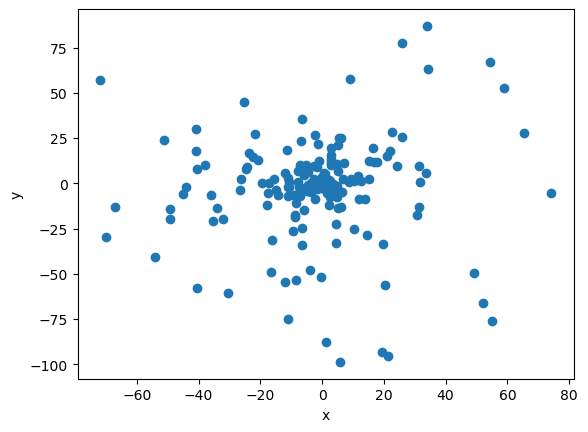

In [153]:
# plot initial positions
def plot_particles(particles):
    positions = np.array([p.position for p in particles])
    plt.scatter(positions[:, 0], positions[:, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plot_particles(particles)

In [154]:
softening_length = 0.01
def compute_forces(particles):
    for particle in particles:
        particle.force[:] = 0.0  # Reset force to zero

    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i != j:
                r = p2.position - p1.position
                distance = np.linalg.norm(r)
                if distance > 0:  # Avoid division by zero
                    force_magnitude = G * p1.mass * p2.mass / (distance**2 + softening_length**2)**(3/2)
                    force_vector = force_magnitude * r
                    p1.force += force_vector

def update_accelerations(particles):
    for particle in particles:
        particle.acceleration = particle.force / particle.mass

def handle_collisions(particles, dt, epsilon=0.1):
    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i < j:  # Avoid double checking pairs
                r = p2.position - p1.position
                distance = np.linalg.norm(r)
                if distance < epsilon:  # Check if particles are close enough to collide
                    # relative_velocity = np.linalg.norm(p1.velocity - p2.velocity)
                    probability = p1.scattering_probability(p2)
                    if random.random() < probability * dt:  # Determine if collision occurs
                        print(f'Collision between particles {i} and {j}')
                        # Elastic collision conserving momentum and energy
                        m1, m2 = p1.mass, p2.mass
                        v1, v2 = p1.velocity, p2.velocity
                        r1, r2 = p1.position, p2.position
                        r_rel = r1 - r2
                        v_rel = v1 - v2
                        r_rel_norm = np.linalg.norm(r_rel)**2
                        if r_rel_norm == 0:
                            continue
                        # Calculate new velocities after collision
                        v1_new = v1 - (2 * m2 / (m1 + m2)) * (np.dot(v_rel, r_rel) / r_rel_norm) * r_rel
                        v2_new = v2 - (2 * m1 / (m1 + m2)) * (np.dot(-v_rel, -r_rel) / r_rel_norm) * (-r_rel)
                        # Update particle velocities
                        p1.velocity, p2.velocity = v1_new, v2_new

compute_forces(particles)
update_accelerations(particles)

In [155]:
def velocity_verlet(particles, dt):
    # Update positions
    for particle in particles:
        particle.position += particle.velocity * dt + 0.5 * particle.acceleration * dt**2
    
    # Compute new forces
    compute_forces(particles)
    update_accelerations(particles)
    
    # Update velocities
    for particle in particles:
        particle.velocity += 0.5 * (particle.acceleration + particle.force / particle.mass) * dt

Collision between particles 74 and 133
Collision between particles 74 and 195
Collision between particles 0 and 62
Collision between particles 11 and 33
Collision between particles 11 and 94
Collision between particles 167 and 198
Collision between particles 34 and 72
Collision between particles 34 and 72
Collision between particles 78 and 161
Collision between particles 157 and 185
Collision between particles 105 and 159
Collision between particles 6 and 23
Collision between particles 95 and 110


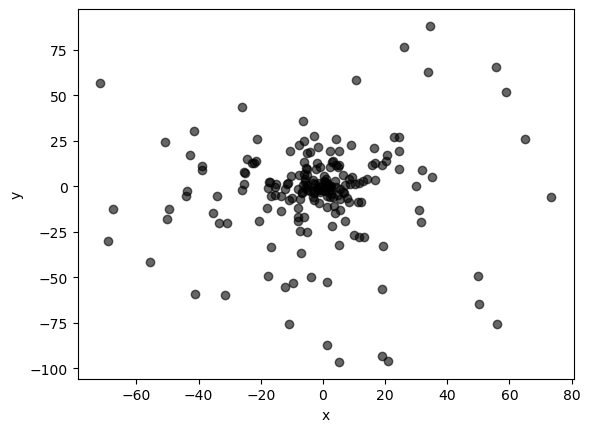

In [156]:
# Time step
dt = 0.01

# Number of steps
num_steps = 100

# Arrays to store positions for plotting
positions = []

# Main loop
for step in range(num_steps):
    positions.append([p.position.copy() for p in particles])
    velocity_verlet(particles, dt)
    handle_collisions(particles, dt)

# Convert positions to numpy array for easier plotting
positions = np.array(positions)

# Plotting the trajectories
for i, particle in enumerate(particles):
    plt.scatter(positions[-1, i, 0], positions[-1, i, 1], color='k', alpha=0.6)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Animations

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_73011/3868429520.py:20: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  scatter.set_data(positions[frame, i, 0], positions[frame, i, 1])


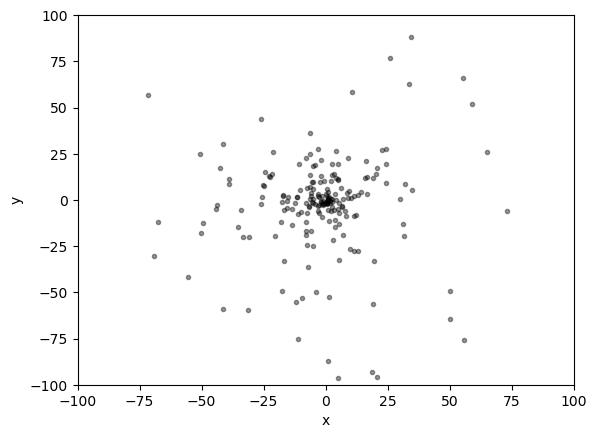

In [158]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('x')
ax.set_ylabel('y')

# Initialize scatter plot for particles
scatters = [ax.plot([], [], 'o', color='k', alpha=0.4, ms=3, label=f'Particle {i+1}')[0] for i in range(len(particles))]

# Initialization function for the animation
def init():
    for scatter in scatters:
        scatter.set_data([], [])
    return scatters

# Animation function which updates the scatter plot
def update(frame):
    for i, scatter in enumerate(scatters):
        scatter.set_data(positions[frame, i, 0], positions[frame, i, 1])    
    return scatters

# Create the animation object
ani = FuncAnimation(fig, update, frames=range(0, num_steps, 1), init_func=init, blit=True)

# Save the animation as a GIF
ani.save('n_body_simulation_100_nfw_sigma_10.gif', writer='pillow', fps=30)

# Display the animation (optional, remove if running in a non-interactive environment)

plt.show()